<a href="https://colab.research.google.com/github/thdgmltjd123/Assignment01/blob/master/20150711_Assignment11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
import numpy as np
import re
import nltk
from sklearn.datasets import load_files
nltk.download('stopwords')
nltk.download('wordnet')
import pickle
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


review_data = load_files(r"/content/drive/My Drive/Colab Notebooks/movie_review",categories = ['pos','neg'])
X, y = review_data.data, review_data.target

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
documents = []

stemmer = WordNetLemmatizer()

for sen in range(0, len(X)):
    #바이트 형을 문자형으로 바꾸면 '같은 것에 \ 이 붙기때문에 그걸 없애주는 변환 
    document = X[sen].decode('utf-8')
    #개행 문자 제거
    document = re.sub(r"\s+"," ",document)
    #문자,숫자가 아닌 것들 모조리 제거(특수문자)
    document = re.sub(r"\W", ' ',document)
    #띄어쓰기 문자 띄어쓰기 형태 모조리 제거
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    #처음에 문자로 시작하고 띄어쓰는 형태 제거
    document = re.sub(r'^[a-zA-Z]\s+', ' ', document)
    #띄어쓰기 문자 띄어쓰기 형태 모조리 제거 한번더 
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    #공백이 여러개 있는 것을 한개로 줄이기
    document = re.sub(r"\s+"," ",document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()
    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)


In [38]:
vectorizer = CountVectorizer(max_features = 3000,min_df =30, stop_words=stopwords.words('english'),max_df = 0.7)
X = vectorizer.fit_transform(documents).toarray()
print(X.shape)
unique_elements, counts_elements = np.unique(X[0], return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))
tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()
print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
X_train, X_test = X_train.T, X_test.T
print(X_train.shape)
print(X_test.shape)

(2002, 3000)
Frequency of unique values of the said array:
[[   0    1    2    3    4    5    6    8]
 [2739  179   53   20    4    1    3    1]]
(2002, 3000)
(3000, 1401)
(3000, 601)


In [0]:
# 초기 값 세타들 만들기
def make_parameter(dim1, dim2):
  return np.random.normal(0,5,size = (dim1, dim2))

# 시그모이드
def sigmoid(z):
  return 1 / (1 + np.exp(-z))

# 미분한 시그모이드
def diff_sigmoid(sigmoid):
  return sigmoid * (1 - sigmoid)

# 이미지 값에 편향 더해주는 함수
def add_bias(data):
  col_len = data.shape[1]
  bias = np.ones((1,col_len),dtype = float)
  data = np.append(bias, data, axis = 0)
  return data

#에너지 함수
def energy(last_layer_sigmoid, onehot_label,theta_li, param_regul):
  hap = 0
  length = 0
  for i in theta_li:
    length += i.shape[0]*i.shape[1]
    hap += np.sum(i**2)
  return np.mean(np.sum(-onehot_label*np.log(last_layer_sigmoid+1e-9)-(1-onehot_label)*np.log(1-last_layer_sigmoid+1e-9),axis = 0)) + (param_regul * hap) / (2*length)

#예측함수  
def predict(X,theta_li):
  pred = np.empty(X.shape[1],dtype = int)
  for i in theta_li:
    bias_X = add_bias(X)
    X = np.dot(i,bias_X)
    X = sigmoid(X)
  
  pred = np.where(X >= 0.5, 1, 0)
  return pred

#정확도 함수
def accuracy(Y_pred, label):
  return np.mean(Y_pred == label)

def gradient(last_layer_sigmoid, theta_li, xyz_li, onehotlabel, param_regul):
  length = len(onehotlabel)
  n = 0
  back_li = []
  ba = back_li.append
  gradient_li = []
  ga = gradient_li.append
  for i in theta_li:
    n += i.shape[0]*i.shape[1] 
  theta_li = theta_li[::-1]
  xyz_li = xyz_li[::-1]
  #back_li 만들기
  for i in range(len(theta_li)):
    if i == 0:
      ba((last_layer_sigmoid - onehotlabel))
    else:
      ba(np.dot(theta_li[i-1][:,1:].T,back_li[i-1]) * diff_sigmoid(xyz_li[i-1]))
  #gradient_li 만들기
  for i in range(len(theta_li)):
    gradient = (np.dot(back_li[i],add_bias(xyz_li[i]).T) / length) + ((param_regul * theta_li[i]) / n)
    ga(gradient)
  gradient_li = gradient_li[::-1]
  return gradient_li

#학습 함수
def fit(X, X_test, Y, Y_test, theta_li, alpha,param_regul):
  #return 시 필요한 array 생성
  train_energy_val = []
  test_energy_val = []
  train_accu_val = [0]
  test_accu_val = [0]
  length = X.shape[1]
  lr = alpha
  #반복 수 8천회
  epoch = 8000
  #진행상황을 알려주는 변수
  count = 1
  for k in range(epoch):
    if(k!=0 and k%800 == 0):
      print("{}% 완료".format(10*count))
      count+=1
    #원본 보존하기
    temp_X = X.copy()
    test_X = X_test.copy()
    #gradient descent를 위한 각 층별 결과물을 저장하는 리스트
    xyz_li = [X_train]
    #forward propagation(train, test)
    for i in theta_li:
      bias_X = add_bias(temp_X)
      test_bias_X = add_bias(test_X)
      temp_X = np.dot(i,bias_X)
      test_X = np.dot(i,test_bias_X)
      temp_X = sigmoid(temp_X)
      test_X = sigmoid(test_X)
      if not np.array_equal(i,theta_li[-1]):
        xyz_li.append(temp_X)
    
    #energy 계산
    temp_energy = energy(temp_X, Y,theta_li, param_regul)
    test_energy = energy(test_X, Y_test,theta_li, param_regul)
    train_energy_val.append(temp_energy)
    test_energy_val.append(test_energy)

    #backward propagation
    gradient_li = gradient(temp_X,theta_li, xyz_li, Y, param_regul)
    for i in range(len(theta_li)):
      theta_li[i] -= lr * gradient_li[i]

    pred = predict(X,theta_li)
    test_pred = predict(X_test,theta_li)
    train_accu_val.append(accuracy(pred,Y))
    test_accu_val.append(accuracy(test_pred,Y_test))
    
  return train_energy_val,train_accu_val,test_energy_val,test_accu_val, pred, test_pred

In [40]:
theta_li = []
# 층별 파라미터 차원에 맞게 정의하기
# single 2layer 2n+d applied
theta_li.append(make_parameter(2,3001))
theta_li.append(make_parameter(1,3))

#학습률
alpha = 2.2
#학습
train_energy_val, train_accu_val, test_energy_val, test_accu_val, y_pred_train, y_pred_test = fit(X_train,X_test,y_train,y_test,theta_li,alpha,1.5)

10% 완료
20% 완료
30% 완료
40% 완료
50% 완료
60% 완료
70% 완료
80% 완료
90% 완료


# **Computation Area is all Done!**

# **Plot the loss curve**

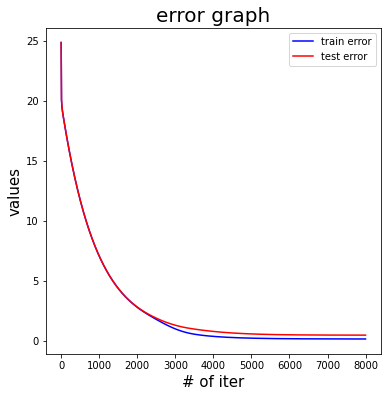

In [41]:
plt.figure(figsize = (6,6))
plt.title("error graph",fontsize = 20)
plt.xlabel("# of iter",fontsize = 15)
plt.ylabel("values", fontsize = 15)
plt.plot(train_energy_val,c = "b",label = "train error")
plt.plot(test_energy_val,c = "r",label = "test error")
plt.legend(loc = "best")
plt.show()

# **Plot the accuracy curve**

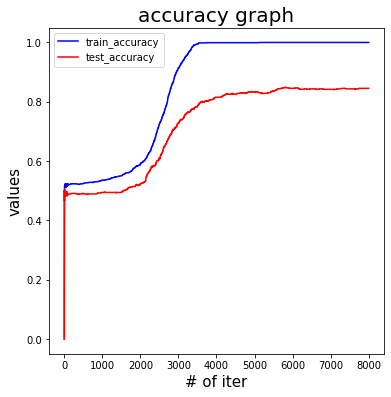

In [42]:
plt.figure(figsize = (6,6))
plt.title("accuracy graph",fontsize = 20)
plt.xlabel("# of iter",fontsize = 15)
plt.ylabel("values", fontsize = 15)
plt.plot(train_accu_val,c = "b",label = "train_accuracy")
plt.plot(test_accu_val,c = "r",label = "test_accuracy")
plt.legend(loc = "best")
plt.show()

# **Plot the quantitative result**

In [43]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_train,y_pred_train[0]))
print(classification_report(y_train,y_pred_train[0]))
print(accuracy_score(y_train, y_pred_train[0]))

print(confusion_matrix(y_test,y_pred_test[0]))
print(classification_report(y_test,y_pred_test[0]))
print(accuracy_score(y_test, y_pred_test[0]))

[[699   0]
 [  0 702]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       699
           1       1.00      1.00      1.00       702

    accuracy                           1.00      1401
   macro avg       1.00      1.00      1.00      1401
weighted avg       1.00      1.00      1.00      1401

1.0
[[249  53]
 [ 40 259]]
              precision    recall  f1-score   support

           0       0.86      0.82      0.84       302
           1       0.83      0.87      0.85       299

    accuracy                           0.85       601
   macro avg       0.85      0.85      0.85       601
weighted avg       0.85      0.85      0.85       601

0.8452579034941764


# **Final Test Accuracy**

In [44]:
print("Final Test Accuracy : {}%".format(test_accu_val[-1]*100))

Final Test Accuracy : 84.52579034941763%
